# DL기초 Neural Network Vectorization implementation 실습

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed to see the same result

## Dataset ##

분류를 위한 데이터를 불러옵니다.

In [29]:
X, Y = load_planar_dataset()

데이터의 개수는 총 400개이고, input값은 2개, y label은 0 또는 1을 나타내는 데이터입니다.

In [30]:
X = X.T
Y = Y.T
print(X.shape) 
print(Y.shape)

(400, 2)
(400, 1)


불러온 데이터를 X의 두가지 feature를 축으로 이용하여,  
Y label이 0인 값은 red point로, 1인 값은 blue point로 시각화하여 나타내 봅니다.

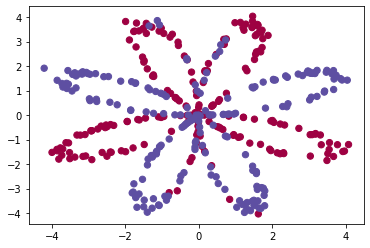

In [31]:
plt.scatter(X[:,0], X[:,1], c=Y, s=40, cmap=plt.cm.Spectral);

## Simple logistic Regression ##
logistic regression을 이용한 이진분류의 결과를 확인해 봅시다

In [32]:
# logistic regression classifier를 이용한 훈련
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X, Y);

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


logistic regression의 정확도: 47 % 


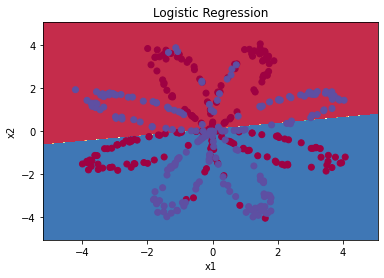

In [33]:
#logistic regression을 이용한 분류의 경계선을 시각화하여 나타내 봅니다.
plot_decision_boundary(lambda x: clf.predict(x), X.T, Y.T)
plt.title("Logistic Regression")

LR_predictions = clf.predict(X)
print ('logistic regression의 정확도: %d ' % float((np.dot(Y.T,LR_predictions) + np.dot(1-Y.T,1-LR_predictions))/float(Y.T.size)*100) +
       '% ')

## Neural Network model

Logistic regression은 위와 같이 선형적이지 않은 복잡한 이진 분류 모델에서 잘 작동하지 않는 모습을 보이는 것을 알 수 있습니다.  
4개의 neuron으로 구성된 1개의 hidden layer를 가진 neural netwok를 통한 classification을 만들어 봅시다!  

**Model**

<img src="classification_kiank.png" style="width:600px;height:300px;">

**Vectorization implementation**:

For one example $x^{(i)}$:
$$neth^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag1$$ 
$$outh^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

**Loss function: Binary cross entropy** 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

### Defining the neural network structure ####

세 가지 변수를 정의해 봅시다
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer 
    - n_y: the size of the output layer

In [34]:
# our model의 경우 다음과 같이 변수 선언
n_x = 2
n_h = 4
n_y = 1

### Initialize the model's parameters ####

neural network의 vectorization implementaion을 위한 parameter를 초기화하는 function을 정의해 봅시다.

In [35]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing parameters:
                    W1 -- weight matrix of shape (n_x, n_h)
                    b1 -- bias vector of shape (1,n_h)
                    W2 -- weight matrix of shape (n_h,n_y)
                    b2 -- bias vector of shape (1,n_y)
    """
    
    np.random.seed(2) 
    
    W1 = np.random.randn(n_x, n_h)*0.01
    b1 = np.zeros((1,n_h))
    W2 = np.random.randn(n_h,n_y)*0.01
    b2 = np.zeros((1,n_y))
    
    assert (W1.shape == (n_x, n_h))
    assert (b1.shape == (1,n_h))
    assert (W2.shape == (n_h,n_y))
    assert (b2.shape == (1,n_y))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [36]:
parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267 -0.02136196  0.01640271]
 [-0.01793436 -0.00841747  0.00502881 -0.01245288]]
b1 = [[0. 0. 0. 0.]]
W2 = [[-0.01057952]
 [-0.00909008]
 [ 0.00551454]
 [ 0.02292208]]
b2 = [[0.]]


## The Loop ##
forward_propagation을 vertorization implemeation을 이용해 구현해 봅시다.

In [37]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (m, n_x), m은 데이터의 개수
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # 앞에서 초기화한 parameter들을 불러옵니다.
    W1 = parameters["W1"]   # W1.shape = (2,4)
    b1 = parameters["b1"]   # b1.shape = (1,4)
    W2 = parameters["W2"]   # W2.shape = (4,1)
    b2 = parameters["b2"]   # b2.shape = (1,1)
    
    Z1 = np.dot(X, W1)+b1   # Z1.shape  = (400,4)
    A1 = np.tanh(Z1)        # A1.shape  = (400,4)
    Z2 = np.dot(A1,W2)+b2   # Z2.shape  = (400,1)
    A2 = sigmoid(Z2)        # A2.shape  = (400,1)
    
    assert(A2.shape == (X.shape[0],1))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [38]:
A2, cache = forward_propagation(X, parameters)
print(A2.shape)

(400, 1)


In [39]:
print("Predictions of Y")
print(A2)

Predictions of Y
[[0.50009991]
 [0.50000903]
 [0.50000459]
 [0.50002241]
 [0.50005938]
 [0.50011542]
 [0.50012491]
 [0.50000097]
 [0.50004169]
 [0.50001658]
 [0.50013498]
 [0.5000571 ]
 [0.50002457]
 [0.50002165]
 [0.50012822]
 [0.50000138]
 [0.50005876]
 [0.50001216]
 [0.50009482]
 [0.5001316 ]
 [0.50001656]
 [0.50013824]
 [0.50015167]
 [0.50013953]
 [0.50012404]
 [0.50008342]
 [0.50011905]
 [0.50006405]
 [0.50011879]
 [0.50013169]
 [0.50010608]
 [0.50013018]
 [0.50012025]
 [0.50012088]
 [0.50012609]
 [0.50012604]
 [0.50010165]
 [0.50010459]
 [0.49984363]
 [0.50003121]
 [0.50012134]
 [0.50013691]
 [0.50014029]
 [0.49977225]
 [0.5000597 ]
 [0.50013489]
 [0.50002936]
 [0.49970988]
 [0.50002785]
 [0.49988318]
 [0.49994131]
 [0.50004467]
 [0.50010169]
 [0.50004232]
 [0.49998648]
 [0.49980418]
 [0.49979445]
 [0.49975394]
 [0.49983475]
 [0.49972628]
 [0.49999722]
 [0.49968954]
 [0.49975971]
 [0.49985958]
 [0.49973701]
 [0.49981344]
 [0.49972501]
 [0.49977401]
 [0.49992223]
 [0.49997615]
 [0

이제 loss를 계산해 봅시다!  

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{7}$$

In [40]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation above
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (number of examples,1)
    Y -- "true" labels vector of shape (number of examples,1)
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[0] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y)+np.multiply(np.log(1-A2),1-Y)
    cost = -np.sum(logprobs)/m
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [41]:
print("현재 loss:",compute_cost(A2,Y))

현재 loss: 0.6931418770706425


vectorization implemetation을 이용한 back propagation은 형태가 조금 더 복잡해 보입니다..  
그렇지만 결국은 chain rule을 이용한 연산이라는 사실!!!!!!  
<img src="grad_summary.png" style="width:600px;height:300px;">

In [42]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (number of examples,2)
    Y -- "true" labels vector of shape (number of examples,1)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[0]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"] 
    A2 = cache["A2"]
    
    dL_dA2 = -Y/A2 + (1-Y)/(1-A2)  #shape = (400,1)
    dA2_dZ2 = A2*(1-A2)           #shape = (400,1)
    dZ2_dW2 = A1                  #shape = (400,4)
    dL_dW2 = np.dot(dZ2_dW2.T,dL_dA2 * dA2_dZ2)/m  # shape = (4,1)
    
    dL_dA2 = Y/A2 - (1-Y)/(1-A2)  #shape = (400,1)
    dA2_dZ2 = A2*(1-A2)           #shape = (400,1)
    dZ2_db2 = 1
    dL_db2 = np.sum(dL_dA2 * dA2_dZ2,axis=0,keepdims=True)/m                  
    
    dL_dZ2 = A2-Y 
    dL_dW2 = np.dot(A1.T,dL_dZ2)/m  # shape = (4,1)
    dL_db2 = np.sum(dL_dZ2,axis=0,keepdims=True)/m
    dL_dZ1 = np.dot(dL_dZ2,W2.T)*(1-np.power(A1,2))  # shape = (400,4)
    dL_dW1 = np.dot(X.T,dL_dZ1)/m
    dL_db1 = np.sum(dL_dZ1,axis=0,keepdims=True)/m
    
    grads = {"dW1": dL_dW1,
             "db1": dL_db1,
             "dW2": dL_dW2,
             "db2": dL_db2}
    
    return grads

In [43]:
grads = backward_propagation(parameters, cache, X, Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00023356  0.00020228 -0.00012333 -0.00051942]
 [-0.00207152 -0.00178824  0.00108879  0.00450942]]
db1 = [[-4.58107332e-08 -4.67803779e-09  2.84912888e-07  1.50684916e-06]]
dW2 = [[-0.00343328]
 [-0.0016449 ]
 [ 0.00146772]
 [-0.00281939]]
db2 = [[-3.184147e-06]]


이제 parameter를 업데이트하여 loss가 minimize될 때까지 업데이트하는 train loop을 만들어 봅시다!

In [44]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
   
    W1 = W1-learning_rate*dW1
    b1 = b1-learning_rate*db1
    W2 = W2-learning_rate*dW2
    b2 = b2-learning_rate*db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [46]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (number of examples,n_x)
    Y -- labels of shape (number of examples,n_y)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = X.shape[1]
    n_y = Y.shape[1]
    loss = []
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        loss.append(cost)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters,loss

In [47]:
parameters,loss = nn_model(X, Y, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.693142
Cost after iteration 1000: 0.285742
Cost after iteration 2000: 0.272007
Cost after iteration 3000: 0.263648
Cost after iteration 4000: 0.257530
Cost after iteration 5000: 0.229378
Cost after iteration 6000: 0.222807
Cost after iteration 7000: 0.219642
Cost after iteration 8000: 0.217450
Cost after iteration 9000: 0.215727
W1 = [[-11.24243254   0.12506579  10.1233384    9.18914519]
 [-13.17795955  -9.70042161  -3.10053954 -10.13727551]]
b1 = [[-0.04986995 -0.04695559  0.37862615  0.0658877 ]]
W2 = [[  6.18599639]
 [-11.88313983]
 [ -3.40283822]
 [ 10.34576668]]
b2 = [[-0.0551953]]


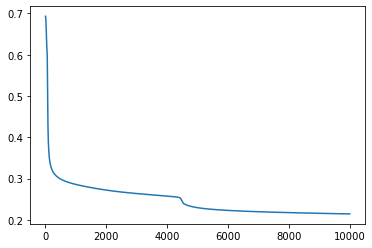

In [48]:
plt.plot(loss)
plt.show()

## Plot the result ##
우리가 구현한 Neural Network 모델이 예측을 잘했는지 확인해 봅시다.

In [49]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2>0.5) 
    
    return predictions

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

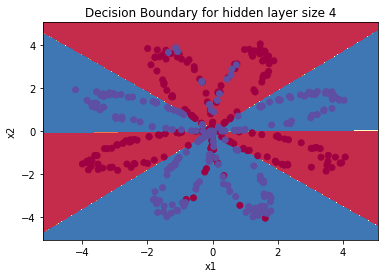

In [50]:
plot_decision_boundary(lambda x: predict(parameters, x), X.T, Y.T)
plt.title("Decision Boundary for hidden layer size " + str(4))

정확도가 얼마나 올라갔는지 확인해 봅시다.

In [51]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(predictions.T,Y) + np.dot(1-predictions.T,1-Y))/float(400)*100) + '%')

Accuracy: 90%


# Keras를 이용한 modeling 
keras api를 이용하면 위와 같은 과정이 전부 매우 간단해집니다!

In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [90]:
inputs = keras.Input(shape=(2,))
x = keras.layers.Dense(4,activation='tanh')(inputs)
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [91]:
model.compile(loss = "binary_crossentropy", 
              optimizer = "adam",
              metrics = ["accuracy"])

In [92]:
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [93]:
print(model.layers[1].get_weights())
print(model.layers[2].get_weights())

[array([[ 0.73417354,  0.17229748, -0.65488005, -0.9335182 ],
       [ 0.16410112, -0.6495421 ,  0.7814009 , -0.59463906]],
      dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
[array([[-0.52282846],
       [ 1.0176215 ],
       [-0.8232473 ],
       [ 0.71786284]], dtype=float32), array([0.], dtype=float32)]


In [ ]:
history = model.fit(X, Y, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7586 - accuracy: 0.4625
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7470 - accuracy: 0.4625
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7363 - accuracy: 0.4600
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7268 - accuracy: 0.4600
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7169 - accuracy: 0.4575
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7086 - accuracy: 0.4575
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7004 - accuracy: 0.4525
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.4525
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6860 - accuracy: 0.4525
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6797 - accuracy: 0.4825

13/13 [==============================] - 0s 1ms/step - loss: 0.6088 - accuracy: 0.5850
Epoch 83/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6086 - accuracy: 0.5850
Epoch 84/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6085 - accuracy: 0.5850
Epoch 85/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6085 - accuracy: 0.5850
Epoch 86/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6084 - accuracy: 0.5800
Epoch 87/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6081 - accuracy: 0.5800
Epoch 88/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6081 - accuracy: 0.5825
Epoch 89/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6079 - accuracy: 0.5825
Epoch 90/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6078 - accuracy: 0.5825
Epoch 91/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6076 - accuracy: 0.5800
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.5992 - accuracy: 0.5825
Epoch 163/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5991 - accuracy: 0.5775
Epoch 164/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5990 - accuracy: 0.5825
Epoch 165/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5989 - accuracy: 0.5800
Epoch 166/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5988 - accuracy: 0.5775
Epoch 167/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5986 - accuracy: 0.5800
Epoch 168/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5985 - accuracy: 0.5850
Epoch 169/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5984 - accuracy: 0.5850
Epoch 170/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5983 - accuracy: 0.5850
Epoch 171/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5982 - accuracy: 0.

13/13 [==============================] - 0s 2ms/step - loss: 0.5889 - accuracy: 0.6075
Epoch 243/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5887 - accuracy: 0.6100
Epoch 244/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5885 - accuracy: 0.6075
Epoch 245/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5884 - accuracy: 0.6100
Epoch 246/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.6075
Epoch 247/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5881 - accuracy: 0.6100
Epoch 248/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5879 - accuracy: 0.6075
Epoch 249/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5878 - accuracy: 0.6075
Epoch 250/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5877 - accuracy: 0.6075
Epoch 251/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5875 - accuracy: 0.

13/13 [==============================] - 0s 2ms/step - loss: 0.5777 - accuracy: 0.6275
Epoch 323/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5775 - accuracy: 0.6275
Epoch 324/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5774 - accuracy: 0.6325
Epoch 325/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5774 - accuracy: 0.6325
Epoch 326/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5772 - accuracy: 0.6325
Epoch 327/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5770 - accuracy: 0.6275
Epoch 328/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5770 - accuracy: 0.6275
Epoch 329/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5768 - accuracy: 0.6275
Epoch 330/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5766 - accuracy: 0.6275
Epoch 331/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5765 - accuracy: 0.

13/13 [==============================] - 0s 1ms/step - loss: 0.5097 - accuracy: 0.8325
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5073 - accuracy: 0.8325
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5048 - accuracy: 0.8350
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5025 - accuracy: 0.8425
Epoch 406/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5001 - accuracy: 0.8425
Epoch 407/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4979 - accuracy: 0.8425
Epoch 408/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4957 - accuracy: 0.8450
Epoch 409/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4936 - accuracy: 0.8425
Epoch 410/1000
13/13 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.87 - 0s 2ms/step - loss: 0.4914 - accuracy: 0.8450
Epoch 411/1000
13/13 [==============================] -

In [ ]:
print(model.layers[1].get_weights())
print(model.layers[2].get_weights())

In [ ]:
def plot_history(history):
    plt.figure(figsize = (10,10))
    for e, (item, value) in enumerate(history.history.items()):
        plt.subplot(2,2,e+1)
        plt.plot(value)
        plt.title(item)
    plt.show()

In [ ]:
plot_history(history)

#### Coursera Deep learning: neural network 강의를 기반으로 작성됐습니다 ####